<a href="https://colab.research.google.com/github/vankiee/computational_literary_analysis/blob/main/Punctuation_is_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Punctuation is Style, Period. 
### Van Kie Liew  
##### Introduction to Computational Literary Analysis (Final Project)


When we read prose, the aspect that strikes us most about the author’s writing style is perhaps their use of structure, symbolism, or vocabulary. While these stylistic devices deserve the appreciation they duly receive, there is one very often overlooked aspect of writing style—punctuation. Even in quantitative analysis of written text, punctuation is discarded along with stop words because they introduce ‘noise’ into the analysis process. However, when we take a look at a sentence, and strip it of everything except punctuation, it might be able to tell us something about the author’s style. For example, 
```
,,,.,—.,’’.,,,’., 
```
is what is left when my opening paragraph is ‘de-worded’. In isolation, it probably might not reveal much. However, when compared with the vast corpora available out there, there may be valuable information that we are consciously removing every time we perform textual analysis. Hence, in this paper, I aim to explore whether the properties of such punctuation sequences are a unique feature of different authors. In particular, I will be comparing the works of two modernist writers, *The Garden Party and Other Stories* by Katherine Mansfield and *Dubliners* by James Joyce. First, we will look at the types of punctuation each author tends to use more frequently. Then, we use the information to attribute texts to the modernist authors in a stylometric analysis. Finally, we examine the sequence of punctuation in each work, and try to identify patterns or styles that the author favors, confirming, or disconfirming, our hypotheses.

Modernism is an umbrella term to describe counter-tradition thought or practice in the form of literature (Childs 1). The industrial revolution in Western society towards the end of the 19th century resulted in people losing their foothold on traditional values and religion. There was less satisfaction and freedom, and more isolation. As people became confused and lost, these social changes forayed into a newfound form of expression—modernism. Modernist novelists thought that the values held within realism-based novels were in conflict with reality at that time. Hence, they decided to pay closer attention to the inner world in their craft. The themes in modernist novels revolve around a constant feeling of alienation, anxiety, and absurdity. Changes in values also led to changes in form. First, modernist novels had an unconventional structure. The authors toyed with the literary fabric of time and space, deconstructing conventional structure and rearranging them in unfamiliar ways. An example of this can be seen in Mansfield and Joyce’s novels, where most short stories start in medias res. There is no formal introduction of the characters or settings; we are thrust into the thick of things, almost as if we have already previously been acquainted with the scene. This is, by design, to expose us to the character’s inner world. The writer further makes use of internal monologue, free association, impersonal narration, and stream of consciousness (Solomon). If modernism as a general category thematizes rupture, displacement, and shock, then punctuation lends its hand in the disruption. It interrupts a character’s train of thought, and in turn, distracts the reader from reading too much into the content—bringing realism to a different level altogether.

In order to examine the stylistic use of punctuation marks by Joyce and Mansfield, I first conducted a frequency analysis on the most common punctuation marks used by both authors.


In [ ]:
!python3 -m spacy download en_core_web_lg

In [7]:
from bs4 import BeautifulSoup
import en_core_web_lg
import pandas as pd
import nltk
import requests
from collections import Counter, defaultdict
import altair as alt
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from mpl_toolkits.axes_grid1 import AxesGrid
from textwrap import wrap

In [8]:
nlp = en_core_web_lg.load()

In [9]:
def riphtml(url):
  html = requests.get(url).text
  soup = BeautifulSoup(html)
  return soup.get_text()

gardenRaw = riphtml('https://www.gutenberg.org/files/1429/1429-h/1429-h.htm')[2495:328660]
dublinRaw = riphtml('https://www.gutenberg.org/files/2814/2814-h/2814-h.htm')[2704:380782]

In [10]:
gardenStories = gardenRaw.split('\r\n\n\n\n')
dublinStories = re.split(r'\r\n\n\n\n\b', dublinRaw)

authorStories = {'mansfield': gardenStories,
                 'joyce': dublinStories}

corpus = defaultdict(dict)

for author, stories in authorStories.items():
  for story in stories:
    if author == 'mansfield':
      delimiter = '\n'
    elif author == 'joyce':
      delimiter = '\n\r\n'
    title, text = story.split(delimiter, 1)
    corpus[author][title] = nlp(text)

In [11]:
def concatDf(df):
  return pd.concat({k: pd.DataFrame(v).T
                      for k, v in df.items()}, axis = 0
                      ).fillna(0) 
                      
to_find = ['.', ',', '”', '-', '?', '!', '—', ';', ':', '....', '...', '’']
punctuation = defaultdict(dict)
punctList = []

for author, stories in corpus.items():
  for title, text in stories.items():
    for token in text:
      if token.text in to_find:
        punctList.append(token.text)
    punctuation[author][title] = punctList
    punctList = []

punctCount = {author: {title: Counter(punct)
                      for title, punct in stories.items()}
              for author, stories in punctuation.items()}

punctDF = concatDf(punctCount)

for index1, index2 in punctDF.index:
  punctDF.loc[index1].loc[index2] = punctDF.loc[index1].loc[index2] / len(corpus[index1][index2]) * 1000

punctDF = punctDF.reset_index()
punctDF = punctDF.rename(columns={'level_0': 'author', 'level_1': 'story'})
punctDFlong = pd.melt(punctDF, id_vars = ['author', 'story'])

In [12]:
# plot stacked bar chart
chart = alt.Chart(punctDFlong).mark_bar(size=20).encode(

    # tell Altair which field to use as Y values and how to calculate
    x=alt.X('author:N', 
            title=None, 
            axis=alt.Axis(labels=False),
            sort=alt.EncodingSortField(op='sum', 
                                       field='mansfield', 
                                       order = 'descending')),

    # tell Altair which field to group columns on
    y=alt.Y('sum(value):Q',
        axis=alt.Axis(
            grid=False,
            title=None)),

    # tell Altair which field to use to use as the set of columns to be  
    #represented in each group
    column=alt.Column('variable:N', 
                      title=None, 
                      header=alt.Header(labelOrient='bottom', 
                                        labelFontSize = 18)),

    order=alt.Order(
      # Sort the segments of the bars by this field
      'value',
      sort='ascending'),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('story:N', 
                    legend=alt.Legend(columns=2),
                    sort=alt.EncodingSortField('author', 
                                               order='descending')),
    
    # hover over stories to see the title
    tooltip=[alt.Tooltip('story:N'), 
             alt.Tooltip('value:N', format=",.2f")]
    )\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).configure_range(
        category = {'scheme': 'redblue'}
    ).properties(
    width=0,
    height=450
)
  
chart

alt.Chart(...)

While it is unsurprising that commas (,) and periods (.) are the top occurring punctuation marks in both novels, Mansfield appears to use a lot more commas than Joyce. In the first paragraph of ‘Bank Holiday’, Mansfield’s short story with the highest proportion of commas, we can already see its abundance in action:

```
A little chap in white canvas shoes, his face hidden under a felt hat like a broken wing, breathes into a flute; and a tall thin fellow, with bursting over-ripe button boots, draws ribbons—long, twisted, streaming ribbons—of tune out of a fiddle. They stand, unsmiling, but not serious, in the broad sunlight opposite the fruit-shop; the pink spider of a hand beats the guitar, the little squat hand, with a brass-and-turquoise ring, forces the reluctant flute, and the fiddler’s arm tries to saw the fiddle in two.
``` 

Connor notes that the comma “fulfils a dizzying multiplicity of functions” (57). Among some are accelerating, iterating, and intensifying, which are elements Mansfield aims to introduce in this short story about the commotion on a public holiday. Unlike the period, a comma only exerts a short-range influence—new elements are added to each other in an exhilarated flurry, mirroring the sensory overload of a busy street during a holiday in the summertime. On the other hand, even Joyce’s top stories pale in comparison when it comes to usage of the commas. In his second highest story in the comma proportion department ‘The Dead’, there are hardly any commas in a long sentence:

```
​​Mary Jane waited on her pupils and saw that they got the best slices and Aunt Kate and Aunt Julia opened and carried across from the piano bottles of stout and ale for the gentlemen and bottles of minerals for the ladies.
```

While Mansfield uses commas to disrupt structure, Joyce achieves the same effect doing the exact opposite. The lack of a short pause between different scenes in the same sentence seems to address the flurry of activity in which there is no chance to take a break from. Besides the liberal use of the comma in ‘Bank Holiday’, we also see em dashes (—) and semicolons (;), both of which Mansfield significantly outdoes Joyce. In fact, the only punctuation mark that Joyce uses more than Mansfield is the colon (:). We can see it in ‘The Sisters’:

``` 
There was no hope for him this time: it was the third stroke.
```
And similarly for ‘Grace’: 

```
Two gentlemen who were in the lavatory at the time tried to lift him up: but he was quite helpless.
```
Joyce’s stories revolve around the theme of paralysis, and by using the colon here in the 2 examples, he manages to evoke a sense of helplessness in the characters. The colon marks the end of a futile attempt at 'one last chance'. 

In the same vein, Mansfield accomplishes this with the use of em dashes to cut off a character’s speech when they are faced with an epiphany that brings them crashing back down onto earth. For instance, in ‘The Lady’s Maid’:

``` 
Last words she ever said was—very slow, “Look in—the—Look—in—” And then she was gone.
```

And in titular ‘The Garden Party’:

```
“Isn’t life,” she stammered, “isn’t life—” But what life was she couldn’t explain.
```

The stylistic punctuation choices of the authors differ in their similar ways of expressing the hurriedness and helplessness of the characters. This could mean that we would potentially be able to perform a stylometric analysis to attempt to differentiate texts belonging to each author.


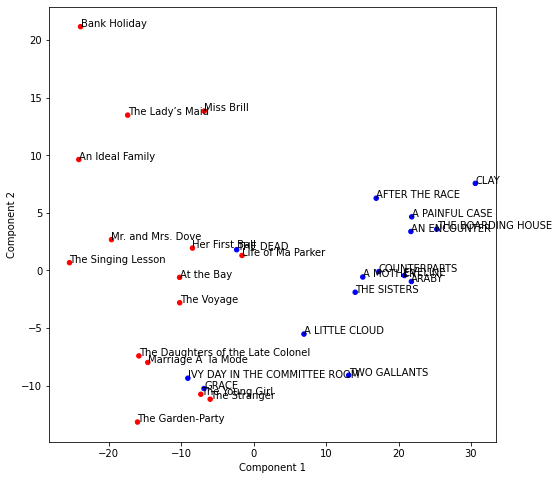

In [ ]:
punctPCA = punctDF.drop(columns='author')

pca = PCA(n_components=2)
punctPCA = punctPCA.set_index('story')
punctReduced = pca.fit_transform(punctPCA)
storyTitles = [title for author, stories in corpus.items() 
                      for title in stories]

df = pd.DataFrame(punctReduced, 
                  columns = ['Component 1', 'Component 2'],
                  index = storyTitles
                  )

ax = df.plot(kind = 'scatter',
              x = 'Component 1', 
              y = 'Component 2', 
             figsize = (8 ,8),
             c = list('r' * 15 + 'b' * 15))

for title, points in df.iterrows():
  ax.annotate(title, points)

As it turns out, punctuation can be a reliable feature in categorizing authorship. For the majority of the works, they lay on either side of a slope that is close to 1, with the exception of two clusters. The first is Joyce’s ‘THE DEAD’ and Mansfield’s ‘Life of Ma Parker’. At a glance, the first few paragraphs of ‘THE DEAD’ and ‘Life of Ma Parker’ seem to contain a lot of single quotation marks (‘), but the usage in the text differs. While ‘THE DEAD’ uses these single apostrophes to attribute possessiveness, such as:

```
….the members of Julia’s choir, any of Kate’s pupils that were grown up enough, and even some of Mary Jane’s pupils too.
```

In the ‘Life of Ma Parker’ it is used deliberately to show, rather than tell us that the character has an accent that is out of the norm in the society that they live in:

```
“Gran, gi’ us a penny!” he coaxed.
“Be off with you; Gran ain’t got no pennies.”
“Yes, you ’ave.”
```
This is one of the many ways Mansfield incorporates subtle commentary about the divides of social class. In England, and especially in the class conscious England of the 1920s, a colloquial accent would mark a person for life, and the middle and upper classes employed a very different sort of vocabulary to those beneath them in the social scale (Kimber 213). This acts to highlight the difference between rich and poor, between those who wield power and those who submit. In ‘Life of Ma Parker’, the titular character is a cleaner who finds out that her grandson had just died a day earlier. Despite being overwhelmed with sadness and regret, she is not allowed any time to mourn her loss, as she has to tend to her employer, the gentleman’s house. Her accent contrasted against the lack thereof in the gentleman delineates the class divide, wherein he disregards her loss and expects her to work as usual. Compared to Joyce’s functional use of the single quotation mark in ‘THE DEAD’, this brings up a limitation of the stylometric analysis. While it can tell us the type and frequency of punctuation used, it fails to address the context, which is paramount in this genre of experimental literature.

Another cluster that found similarities between the authors are Joyce’s ‘IVY DAY IN THE COMMITTEE ROOM’ and ‘GRACE’ coupled with Mansfield’s ‘The Young Girl’ and ‘The Stranger’. The most striking feature of these few stories is that they contain a lot of dialogue, hence double apostrophes (“). This is aberrant of Joyce’s usual works; he even goes so far as to call quotation marks "perverted commas" (Reynolds 99). The addition of the double quotation marks in lieu of his preferred dashes were a result of his publisher’s pleas, yet even within his works there is hardly much dialogue to begin with. Perhaps this shift is to accentuate the emptiness of words whenever they do appear in his prose, especially when uttered by institutions that he was not very fond of: political parties and the church.

In Mansfield’s story, too, the narrator’s dialogue underscores the lack thereof in their counterparts. For ‘The Stranger’, Mr Hammond appears to be insensitive to his wife’s experience witnessing a stranger die right before her eyes. In ‘The Young Girl’, the titular character is hardly able to speak her mind, and when she does respond, she seems distant:

```
“I—don’t—know,” she said slowly, from that far place.
“I suppose you prefer it to London. It’s more—more—”
When I didn’t go on she came back and looked at me, very puzzled. “More—?”
```
The conversations held are hollow, and silent from purpose and sincerity. This interesting use of dialogue and excessive punctuation serves an opposing goal. Perhaps this is why the stories have clustered together, despite the absence of context from the stories themselves.

In order to confirm our hypothesis, we would have to see these punctuation marks in successive order, and observe their patterns to know if that is the reason behind the curious clustering. I converted the lists of punctuation in successive order into their respective number keys, which you can see in the colorbar below.

In [ ]:
punctuationTruncated = {author: {title: punct[:225] 
                                 for title, punct in stories.items()}
                        for author, stories in punctuation.items()}
punct_to_num = {punct: num for num, punct in enumerate(to_find)}
concat = concatDf(punctuationTruncated)
to_num_df = concat.replace(punct_to_num)

square_list = defaultdict(dict)

for index1, index2 in to_num_df.index:
  row = to_num_df.loc[index1].loc[index2]
  to_np = row.to_numpy()
  squared = to_np.reshape(15, 15)
  square_list[index1][index2] = squared

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


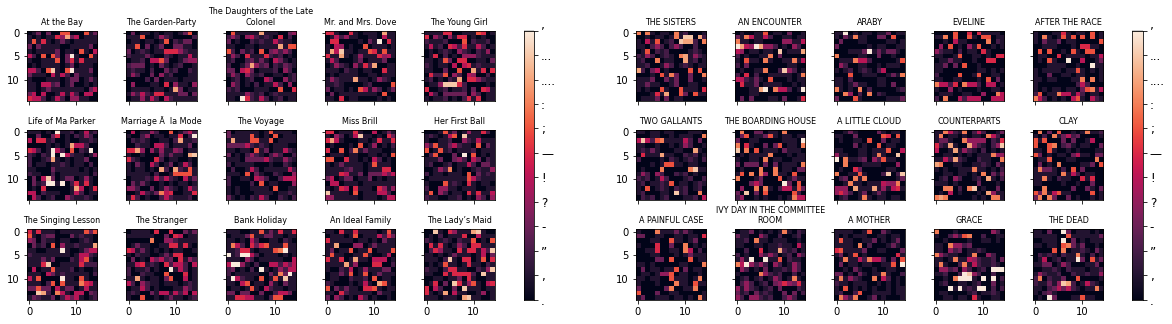

In [ ]:
fig = plt.figure(figsize=(20, 25))
fig_pos = 121

for author, stories in square_list.items():
  grid = AxesGrid(fig, fig_pos,
                  nrows_ncols=(3, 5),
                  axes_pad=0.4,
                  share_all=True,
                  label_mode="L",
                  cbar_location="right",
                  cbar_mode="single",
                  )

  for val, ax, title in zip(stories.values(), grid, stories.keys()):
      im = ax.imshow(val, cmap = 'rocket', vmin=0, vmax=11)
      ax.set_title('\n'.join(wrap(title,25)), fontsize=8)

  grid.cbar_axes[0].colorbar(im, ticks=range(12))

  for cax in grid.cbar_axes:
      cax.toggle_label(True)
      cax.set_yticklabels(punct_to_num.keys(), fontsize = 12)

  fig_pos += 1

plt.show()

The distribution of punctuation marks denoted by color between authors look pretty telling here. There is a distinct dearth of punctuation such as exclamation marks (!), em dashes and semicolons in Joyce’s collection, as we have already noted before. However, he does tend to use more ellipses and single quotation marks. Note that this only includes the first 225 punctuation marks in each story (as 235 was the lower limit of all the stories, but since I wanted to visualize it as a square, I opted for a perfect square), so it may not be very consistent with the frequency analysis above.

To return to our clustering, it seems that while my initial hypothesis cannot be fully refuted, the current sampling is also unable to capture the full story here. To my surprise, stories from Joyce that appear very alike Mansfield’s collection in this heatmap visual, such as ‘EVELINE’ and ‘AFTER THE RACE’, do not cluster together in the stylometry analysis. Perhaps random sampling from each short story would have improved accuracy, but I was hesitant to include that as that means it will not be consistent from story to story. 

From the computational and close reading analyses, we have seen that each author’s use of punctuation has its own unique distribution as well as their own purpose in each story, reflecting the times that they live in. Although the distribution and function are sometimes similar to each other, there remains a large agreement for stories within each author, confirming once again that punctuation can be a definitive indicator of style. 

As a wise man once said, 

```
Punctuation, is? fun!
``` 
(Daniel Keyes, Flowers for Algernon).


# Works cited

Childs, Peter. Modernism. Taylor & Francis, 2016.

Connor, Steven. Beckett, Modernism and the Material Imagination. Cambridge UP, 2014.

Kimber, Geraldine M. KATHERINE MANSFIELD: THE VIEW FROM FRANCE. 2007. U of Exeter, PhD dissertation.

Reynolds, Mary T. "Joyce and Miss Weaver." James Joyce Quarterly, vol. 19, no. 4, 1982, pp. 373-403, JSTOR. www.jstor.org/stable/25476463. Accessed 16 Aug. 2021.

Solomon, Susan. NEW WRITING: MODERNISM, PUNCTUATION, AND THE INTERMEDIAL TEXT. 2013. BROWN U, PhD dissertation. 